# Purpose

The purpose of this notebook is to begin to perform some NLP processes to perform an analysis on the text.  For this, I will use a sentiment analysis using the Vader Lexicon and TFIDF analysis

In [207]:
# import relevant libraries

# for data manipulation and visualization
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# for language processing
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

## Data Cleaning

The first part of this analysis is to clean the data.  The steps I took are as follows.

1. Import the data and make the comments column a string type (there were issues with some comments loading in correctly)
2. Load in Stopwords from the nltk library and punctuations from the string library.  Remove any unneeded words or characters

In [208]:
# import data
df = pd.read_csv('fullCommentDataset.csv')

# ensure the comments is a string column
df['comments'] = df['comments'].astype('str')

# load in the stopwords and punctucation lists
stopwords = nltk.corpus.stopwords.words('english')
punctuation = punctuation.replace("'","") #remove ' because its important for context

# remove punctuation, stopwords, and make everythign lowercase
no_punct = df['comments'].apply(lambda x: ''.join([l for l in x if l not in punctuation])) # goes letter by letter
df['no_stop'] = no_punct.apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stopwords)])) # with split, goes word by word

## Sentimenty Intensity Analysis

For the Sentiment Analysis, I used the Sentiment Intenisty Analyzer that produces 4 values to analyze the sentiment.

1. Negative Sentiment
2. Neutral Sentiment
3. Positive Sentiment
4. Compound Sentiment

While 1-3 may be self explainatory, the compound sentiment is an "aggregate" value of the prior 3 if you will going on a scale from -1 to 1 instead of 0 to 1 like the others where -1 is completely negative, 0 is neutral, and 1 is positive.  This allows us to use a single metric when looking at the analytics.

In [209]:
# define the sentiment analyzer and apply to each comment
sia = SentimentIntensityAnalyzer()
comment_sentiment = df['no_stop'].apply(lambda x: sia.polarity_scores(x))

# write each of the sentiment values to the dataframe
neg_sentiment = []
neu_sentiment = []
pos_sentiment = []
compound_sentiment = [] # compound sentiment is combining neg and pos on a scale from -1 to 1

for item in comment_sentiment:
    neg_sentiment.append(item['neg'])
    neu_sentiment.append(item['neu'])
    pos_sentiment.append(item['pos'])
    compound_sentiment.append(item['compound'])

df['neg_sentiment'] = neg_sentiment
df['neu_sentiment'] = neu_sentiment
df['pos_sentiment'] = pos_sentiment
df['compound_sentiment'] = compound_sentiment

To gain a visualization of the number of likes vs the sentiment, I created the plot below.  Note that I used Seaborn here instead of plotly (which I use later on) because the sheer number of data points creates a large lag on my computer. From the visualization, it looks like either staying completely neutral or going for a positive sentiment would produce the highest number of likes.

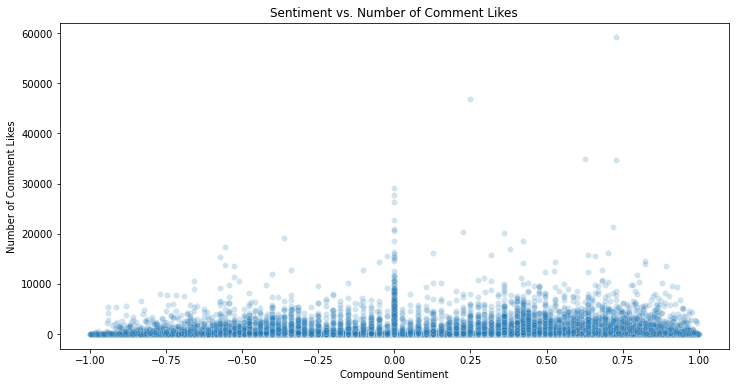

In [210]:
plt.figure(figsize = (12,6))

ax = sns.scatterplot(data = df,
                    x = 'compound_sentiment',
                    y = 'likesCount',
                    alpha = 0.2)
ax.set(title = 'Sentiment vs. Number of Comment Likes',
       xlabel = 'Compound Sentiment',
       ylabel = 'Number of Comment Likes')

plt.show()

## TF-IDF Analysis

TF-IDF analysis stands for Term Frequency - Inverse Document Frequency and is a statistic that is intended to reflect how important a word is to a document in a collection.  While this is inheintly a very mathematical topic, a pratical application to help others gain an understanding of the importance of this value is to have a business or content creator to select specific, unique words in their demographic to get picked up more readily by search engines.

Specifically, here, the TF portion counts the number of times a certain word appears in a comment and the IDF portion compares all the comments and devalues the weight of a comment if the word is used in a lot of comments.  Between the two, they balance out and higher values means words are rarer in the data set.

In [211]:
# complete the tfidf analysis on the comments 
tfidf_vectorizer = TfidfVectorizer()
# this produces x rows (the number of tweets) by y columns (the ratings of unique words)
X = tfidf_vectorizer.fit_transform(df['no_stop'])

Unfortunately, when calculating the tf-idf, it isn't possible for my computer to load an array that big; so, for this analysis, I am going to take the top and bottom 100 comments filtered by having more than 2 likes and see if there is any relation between these and the tfidf values.  Note that since I'm averaging them by comment, the values are small; however, looking at the comments, I do not see a trend between the tf-idf value and the numbe rof likes something gets.

In [212]:
# tfidf analysis for top and bottom 100 comments with at least 2 likes as I can't perform this 
# with the entire dataset as its too much data
filtered_by_likes = df[(df['likesCount'] >= 2)]
top_100 = filtered_by_likes.nlargest(100, columns = 'likesCount')
bot_100 = filtered_by_likes.nsmallest(100, columns = 'likesCount')
topAndBot = pd.concat([top_100, bot_100]).sort_values('likesCount', ascending=False)

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(topAndBot['comments'])

# take the average of the values and add to the dataframe
topAndBot['tfidf_average'] = np.average(X.toarray(), axis = 1)

In [213]:
ax = px.scatter(data_frame = topAndBot,
                x = 'tfidf_average',
                y = 'likesCount',
                hover_name = 'comments',
                opacity = 0.4)
ax.update_layout(
    title = 'TF-IDF Average vs. Number of Comment Likes',
    xaxis_title = 'TF-IDF Average',
    yaxis_title = 'Number of Comment Likes'
)

## Engagement by Time

The last piece of analysis I would like to do in this notebook is to view how many comments each video got by time uploaded.  As a YouTube channel grows, I'd imagine the amount of comments should grow with it and this visualization is just to gain perspective on what has and hasn't gotten several comments.

Looking at the graph, after mid 2019 where this YouTube channel started posting videos at a much higher frequency, the numner of comments also started to rise.  Also, interestingly, the variance has gone up significantly with more recent videos gaining up to over 6400 comments.  There is a small dip after mid 2021, though I'm not familiar enough with the domain to know if this is normal and will balance out after the videos have more time to collect comments or if 99% of all comments come in the first week a video is posted.

In [214]:
dff = df.groupby(['uploadTime','title']).comments.count().reset_index()
dff['uploadTime'] = pd.to_datetime(dff['uploadTime'])

ax = px.scatter(data_frame=dff,
                x = 'uploadTime',
                y = 'comments',
                hover_name='title',
                opacity = 0.3)

ax.update_layout(
    title = 'Video Upload Date vs. Number of Parent Comments Posted',
    xaxis_title = 'Video Upload Date',
    yaxis_title = 'Number of Comments Posted'
)

For the final portion of this project, I will use this data in a dash dashboard to display to an end user.  For speed sake, I'll output the dataframe to a csv to load.

In [215]:
df.to_csv('fullCommentDatasetWithSentiment.csv', index = False, encoding = 'utf-8-sig')